## ARCH and GARCH Models

https://github.com/bashtage/arch Package NB

In [2]:
! pip install arch

  Using cached arch-5.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (906 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)


In [3]:
import arch
from arch import arch_model
from arch.univariate import GARCH
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
import math
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from arch.univariate import ARX # autoregressive model on max loss returns, 1 3, 12 lags
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

### Prep Data

In [4]:
# High Frequency Data
features_to_load = [
    "midprice_mean",
    "traded_price_mean"

]

# Last 2 weeks
end_date = datetime.datetime.now(datetime.timezone.utc)
start_date = end_date - datetime.timedelta(days=90)

# Choose buckketing
time_agg = "60sec" #60sec

high_freq= load_features(
    "ftx", "BTCUSDP", time_agg, start_date, end_date, features_to_load
)
high_freq.to_csv("1Min_BTCUSDP_March23_30.csv")

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 0.65s: 100%|██████████| 3/3 [00:00<00:00,  4.63query/s]                                  
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 450908/450908 [00:18<00:00, 24700.80rows/s]


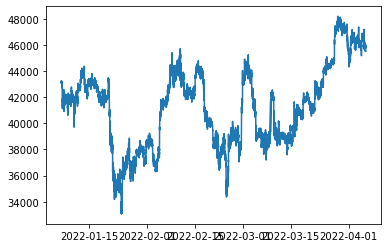

In [5]:
plt.plot(high_freq['midprice_mean'])

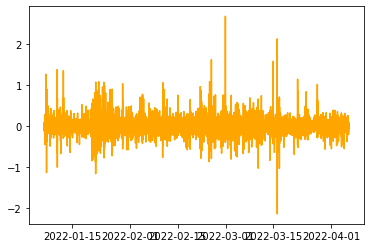

In [6]:
high_freq['return']=100 * high_freq['midprice_mean'].pct_change()
plt.plot(high_freq['return'].dropna(),color='orange')

In [7]:
high_freq=high_freq.dropna()
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return
timestamp,,,,,
2022-01-06 20:55:00+00:00,ftx,BTCUSDP,43145.125135,43136.794554,-0.072911
2022-01-06 20:56:00+00:00,ftx,BTCUSDP,43126.302452,43121.828909,-0.043626
2022-01-06 20:57:00+00:00,ftx,BTCUSDP,43163.570044,43157.028490,0.086415
2022-01-06 20:58:00+00:00,ftx,BTCUSDP,43203.597444,43206.263780,0.092734
2022-01-06 20:59:00+00:00,ftx,BTCUSDP,43196.067276,43212.957333,-0.017429
...,...,...,...,...,...
2022-04-05 23:55:00+00:00,ftx,BTCUSDP,45511.904116,45502.423676,-0.092108
2022-04-05 23:56:00+00:00,ftx,BTCUSDP,45490.486916,45491.202346,-0.047058
2022-04-05 23:57:00+00:00,ftx,BTCUSDP,45524.781169,45523.651042,0.075388


In [8]:
def generate_max(series): 
    '''
    Here is largest negative return for  60 minute buckets consisting of 1 min increments
    
    '''
    
    max_values=pd.Series([])
    for i in range(0,math.floor(len(series.values)/60)):  # hourly 
      
        max_elt=min(series[i*60:(i+1)*60])
        
        
        max_values=max_values.append(pd.Series([max_elt],index=[series.index[i*60]])) # index 
 
    
    return -max_values # view losses as positive

In [9]:
max_series=generate_max(high_freq['return'])

<ipython-input-8-979300edec30>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  max_values=pd.Series([])


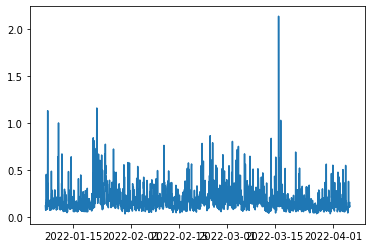

In [10]:
plt.plot(max_series)

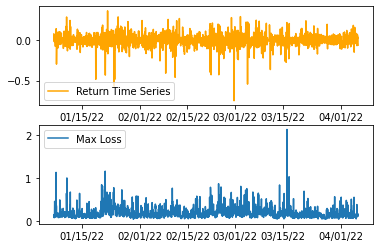

In [11]:
fig,ax = plt.subplots(2,1)


ax[1].plot(max_series, label='Max Loss')
ax[0].plot(-high_freq['return'][::60], label='Return Time Series',color='orange') # negative, sampled every 60 seconds
ax[0].legend()
ax[1].legend()
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))

In [12]:
max_series

2022-01-06 20:55:00+00:00    0.119672
2022-01-06 21:55:00+00:00    0.096875
2022-01-06 22:55:00+00:00    0.074290
2022-01-06 23:55:00+00:00    0.146885
2022-01-07 00:55:00+00:00    0.075547
                               ...   
2022-04-05 18:31:00+00:00    0.131620
2022-04-05 19:31:00+00:00    0.123019
2022-04-05 20:31:00+00:00    0.122702
2022-04-05 21:31:00+00:00    0.107088
2022-04-05 22:31:00+00:00    0.154276
Length: 2129, dtype: float64

## Fitting a Frechet / Inverse Weibull Dist 

### Break Train set into two period
- One to estimate Location parameter,
- Fix location param, allow time-varying shape and scale

In [13]:
global_shape,global_loc,global_scale=invweibull.fit(max_series[:750])
global_shape,global_loc,global_scale

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(2.7080150836146655, -0.03717100387940473, 0.1580649516530977)

No handles with labels found to put in legend.


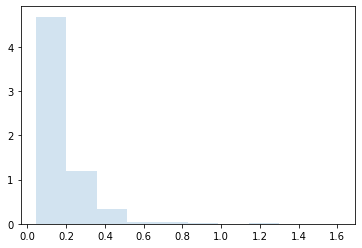

In [14]:
r = invweibull.rvs(global_shape,loc=global_loc,scale=global_scale, size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

## Empirical Data

No handles with labels found to put in legend.


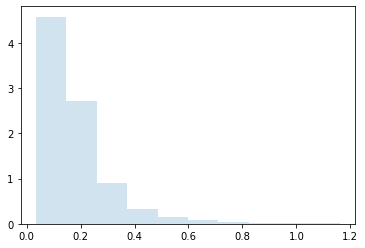

In [15]:
plt.hist(max_series[:750], density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

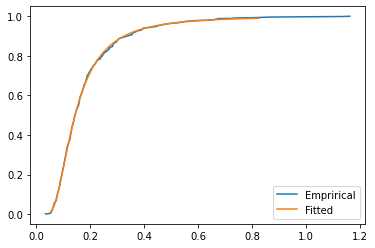

In [16]:
### Comparing Static distributions
ecdf=ECDF(max_series[:750])
plt.plot(ecdf.x,ecdf.y,label='Emprirical')

n=100
x = np.linspace(invweibull.ppf(0.01, global_shape,loc=global_loc,scale=global_scale),
                invweibull.ppf(0.99, global_shape,loc=global_loc,scale=global_scale), n)
frechet_cdf=invweibull.cdf(x,global_shape,loc=global_loc,scale=global_scale)
plt.plot(x,frechet_cdf,label='Fitted')
plt.legend()


**Notes**
- Exhibited is empirical pdf and cdf against the fitted frechet distribution off global trained loc/scale/shape parameters
- This is a static approach, no time varying is incorporated

# Incorporating time varying parameters 

### 
- Samples 750-1500
- Vary time intensive do not rerun frequently


In [42]:
k= 750# num samples

time_vary=pd.DataFrame()
time_vary['return']=-high_freq['return'][::60]
time_vary['max_loss']=max_series


shape_vals=pd.Series([global_shape],index=[max_series.index[749]])
loc_vals=pd.Series([global_loc],index=[max_series.index[749]])
scale_vals=pd.Series([global_scale],index=[max_series.index[749]])

i=0
for index,elt in max_series[750:1500].iteritems(): 
    
    shape,loc,scale=invweibull.fit(max_series[:750+i],floc=global_loc) # fit all data up until observ, fix location param 
    
    shape_vals=shape_vals.append(pd.Series([shape],index=[index]))
    loc_vals=loc_vals.append(pd.Series([loc],index=[index]))
    scale_vals=scale_vals.append(pd.Series([scale],index=[index]))
    i=i+1
        
time_vary['shape']=shape_vals
time_vary['loc']=loc_vals
time_vary['scale']=scale_vals
time_vary['shape']=time_vary['shape'].bfill()
time_vary['loc']=time_vary['loc'].bfill()
time_vary['scale']=time_vary['scale'].bfill()
time_vary.to_csv('time_vary.csv')

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [43]:
time_vary

,return,max_loss,shape,loc,scale
timestamp,,,,,
2022-01-06 20:55:00+00:00,0.072911,0.119672,2.708015,-0.037171,0.158065
2022-01-06 21:55:00+00:00,0.009684,0.096875,2.708015,-0.037171,0.158065
2022-01-06 22:55:00+00:00,0.007518,0.074290,2.708015,-0.037171,0.158065
2022-01-06 23:55:00+00:00,-0.021278,0.146885,2.708015,-0.037171,0.158065
2022-01-07 00:55:00+00:00,0.009594,0.075547,2.708015,-0.037171,0.158065
...,...,...,...,...,...
2022-04-05 19:31:00+00:00,0.012781,0.123019,NaN,NaN,NaN
2022-04-05 20:31:00+00:00,0.036454,0.122702,NaN,NaN,NaN
2022-04-05 21:31:00+00:00,-0.009825,0.107088,NaN,NaN,NaN


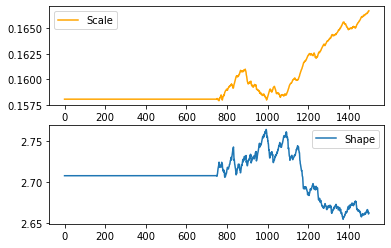

In [21]:
fig,ax = plt.subplots(2,1)


ax[1].plot(time_vary['shape'].values, label='Shape')
ax[0].plot(time_vary['scale'].values, label='Scale',color='orange') # negative, sampled every 60 seconds
ax[0].legend()
ax[1].legend()


### MLE Estimation of parameters

In [22]:
arc_model=pd.read_csv('time_vary.csv')
arc_model=arc_model.dropna() #ARC model only utilizes train set 
arc_model

,timestamp,return,max_loss,shape,loc,scale
0,2022-01-06 20:55:00+00:00,0.072911,0.119672,2.708015,-0.037171,0.158065
1,2022-01-06 21:55:00+00:00,0.009684,0.096875,2.708015,-0.037171,0.158065
2,2022-01-06 22:55:00+00:00,0.007518,0.074290,2.708015,-0.037171,0.158065
3,2022-01-06 23:55:00+00:00,-0.021278,0.146885,2.708015,-0.037171,0.158065
4,2022-01-07 00:55:00+00:00,0.009594,0.075547,2.708015,-0.037171,0.158065
...,...,...,...,...,...,...
1495,2022-03-10 04:18:00+00:00,-0.037499,0.421479,2.664901,-0.037171,0.166578
1496,2022-03-10 05:18:00+00:00,-0.057564,0.346288,2.662853,-0.037171,0.166638
1497,2022-03-10 06:18:00+00:00,0.022398,0.143763,2.661471,-0.037171,0.166691
1498,2022-03-10 07:18:00+00:00,0.021853,0.174603,2.662375,-0.037171,0.166687


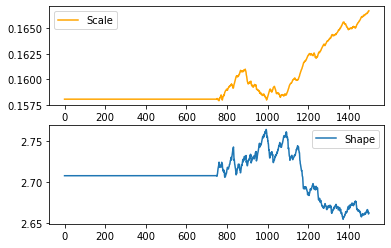

In [23]:
fig,ax = plt.subplots(2,1)


ax[1].plot(arc_model['shape'].values, label='Shape')
ax[0].plot(arc_model['scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()


## Estimating coefficients from our train set

In [24]:
exog=-arc_model['max_loss'][749:-1].values 


In [25]:
mod = AutoReg(np.log(arc_model['shape'][750:].values),1,trend='c',exog=np.exp(exog))
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  750
Model:                   AutoReg-X(1)   Log Likelihood                4793.695
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 06 Apr 2022   AIC                            -15.627
Time:                        20:57:41   BIC                            -15.603
Sample:                             1   HQIC                           -15.618
                                  750                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -7.61e-06      0.001     -0.006      0.995      -0.002       0.002
y.L1           0.9955      0.001    791.205      0.000       0.993       0.998
x1             0.0054      0.000     33.151      0.0

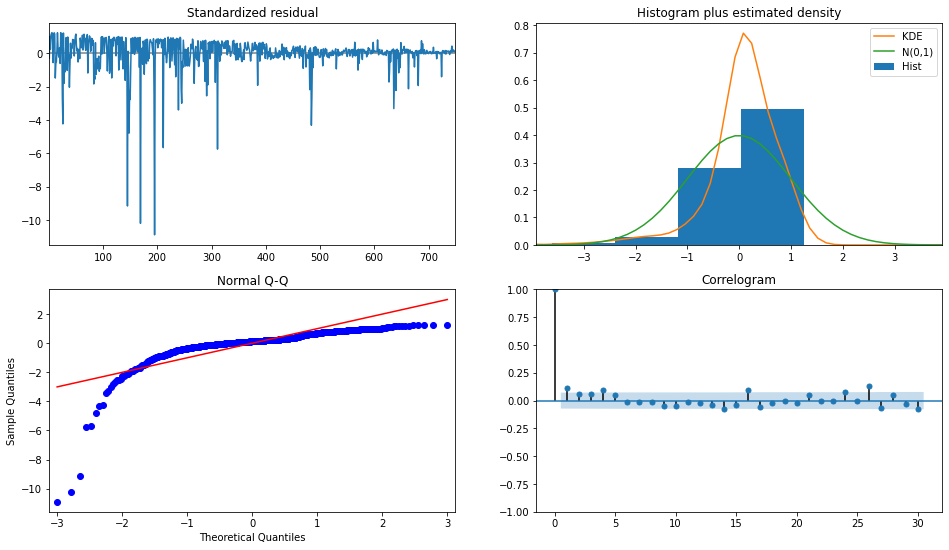

In [26]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model -> should be normal
# Estimated density against N(0,1)
# Correlogram shows acf function 

In [27]:
mod = AutoReg(np.log(arc_model['scale'][750:].values),1,trend='c',exog=np.exp(exog))
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  750
Model:                   AutoReg-X(1)   Log Likelihood                5361.154
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 06 Apr 2022   AIC                            -17.143
Time:                        20:57:55   BIC                            -17.118
Sample:                             1   HQIC                           -17.133
                                  750                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      2.031      0.042    5.36e-05       0.003
y.L1           0.9994      0.000   2394.750      0.000       0.999       1.000
x1            -0.0030   7.67e-05    -39.297      0.0

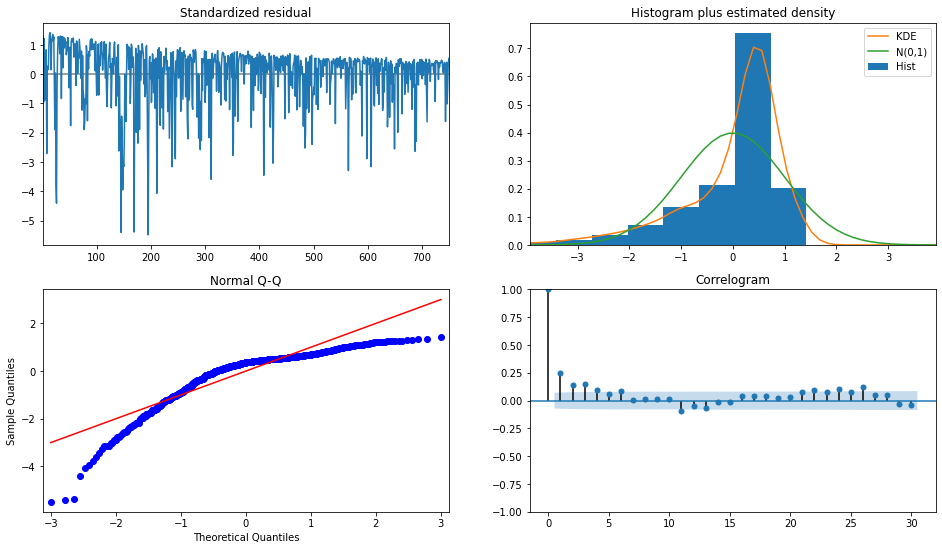

In [28]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model
# Estimated density against N(0,1)
# Correlogram shows acf function 

# Test Set

In [41]:
time_vary['loc']=time_vary['loc'].ffill()
for x,row in time_vary.iterrows():
    if not np.isnan(row['shape']) and not np.isnan(row['scale']) :
        continue
    row['shape']=2 # walk forward from our eqns
    row['scale']=2 # walk forward 

time_vary

,return,max_loss,shape,loc,scale
timestamp,,,,,
2022-01-06 20:55:00+00:00,0.072911,0.119672,2.708015,-0.037171,0.158065
2022-01-06 21:55:00+00:00,0.009684,0.096875,2.708015,-0.037171,0.158065
2022-01-06 22:55:00+00:00,0.007518,0.074290,2.708015,-0.037171,0.158065
2022-01-06 23:55:00+00:00,-0.021278,0.146885,2.708015,-0.037171,0.158065
2022-01-07 00:55:00+00:00,0.009594,0.075547,2.708015,-0.037171,0.158065
...,...,...,...,...,...
2022-04-05 19:31:00+00:00,0.012781,0.123019,2.000000,-0.037171,2.000000
2022-04-05 20:31:00+00:00,0.036454,0.122702,2.000000,-0.037171,2.000000
2022-04-05 21:31:00+00:00,-0.009825,0.107088,2.000000,-0.037171,2.000000


## CVAR Estiamtion and Analysis

## Scale Parameter comparison to GARCH on Midprice Series

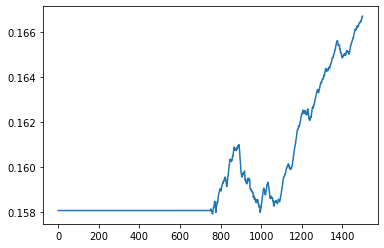

In [29]:
plt.plot(arc_model['scale'])

In [149]:
am = arch_model(arc_model['return'][999:-1],rescale=True)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 1423.9092351454635
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1336.5672939625204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1336.5672939625204
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1336.57
Distribution:                  Normal   AIC:                           2681.13
Method:            Maximum Likelihood   BIC:                           2701.23
                                        No. Observations:                 1124
Date:                Wed, Apr 06 2022   Df Residuals:                     1123
Time:       

In [150]:
res.conditional_volatility

999     0.811847
1000    0.794892
1001    0.774723
1002    0.825615
1003    0.803855
          ...   
2118    0.585322
2119    0.584062
2120    0.574493
2121    0.572731
2122    0.563625
Name: cond_vol, Length: 1124, dtype: float64

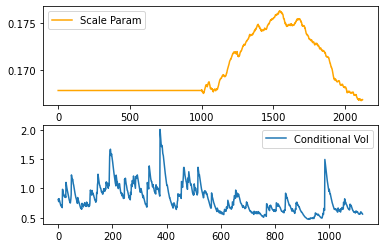

In [151]:
fig,ax = plt.subplots(2,1)


ax[1].plot(res.conditional_volatility.values, label='Conditional Vol')
ax[0].plot(arc_model['scale'].values, label='Scale Param',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()
